In [1]:
import matplotlib.pyplot as plt

In [27]:
!pip install pyspark
!pip install seaborn
!pip install plotly


In [21]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

In [4]:
ipl_data='E:\Wipro Project\Wipro Project\Datasets\IPL_Match.csv'
result_data= 'E:\Wipro Project\Wipro Project\Datasets\Result_Dataset.csv'

In [5]:
spark = SparkSession.builder.appName(name='Cricket Analysis').getOrCreate()

In [6]:
df_ipl=spark.read.csv(path=ipl_data,header=True,inferSchema=True)


In [7]:
df_ipl.show()

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-------------+----------+----------+
|Match_SK|match_id|               Team1|               Team2|match_date|Season_Year|          Venue_Name| City_Name|Country_Name|         Toss_Winner|        match_winner|Toss_Name|Win_Type|Outcome_Type|    ManOfMach|Win_Margin|Country_id|
+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-------------+----------+----------+
|       0|  335987|Royal Challengers...|Kolkata Knight Ri...| 4/18/2008|       2008|M Chinnaswamy Sta...| Bangalore|       India|Royal Challengers...|Kolkata Knight Ri...|    field|    runs|      Result|  BB McCullum|       140|         1|
|       1|  335988|     Kings XI Punjab|

In [8]:
df_ipl.printSchema()

root
 |-- Match_SK: integer (nullable = true)
 |-- match_id: integer (nullable = true)
 |-- Team1: string (nullable = true)
 |-- Team2: string (nullable = true)
 |-- match_date: string (nullable = true)
 |-- Season_Year: integer (nullable = true)
 |-- Venue_Name: string (nullable = true)
 |-- City_Name: string (nullable = true)
 |-- Country_Name: string (nullable = true)
 |-- Toss_Winner: string (nullable = true)
 |-- match_winner: string (nullable = true)
 |-- Toss_Name: string (nullable = true)
 |-- Win_Type: string (nullable = true)
 |-- Outcome_Type: string (nullable = true)
 |-- ManOfMach: string (nullable = true)
 |-- Win_Margin: string (nullable = true)
 |-- Country_id: integer (nullable = true)



In [9]:
df_ipl.first()

Row(Match_SK=0, match_id=335987, Team1='Royal Challengers Bangalore', Team2='Kolkata Knight Riders', match_date='4/18/2008', Season_Year=2008, Venue_Name='M Chinnaswamy Stadium', City_Name='Bangalore', Country_Name='India', Toss_Winner='Royal Challengers Bangalore', match_winner='Kolkata Knight Riders', Toss_Name='field', Win_Type='runs', Outcome_Type='Result', ManOfMach='BB McCullum', Win_Margin='140', Country_id=1)

In [10]:
df_ipl.createOrReplaceTempView('ipl')


In [11]:
total_matches=spark.sql('select Venue_Name as Stadium,count(Team1) as Total_Matches from ipl group by Venue_Name')

total_matches.show()

+--------------------+-------------+
|             Stadium|Total_Matches|
+--------------------+-------------+
|Dubai Internation...|            7|
|Himachal Pradesh ...|            9|
|Sardar Patel Stad...|           12|
|Punjab Cricket As...|           35|
|    Barabati Stadium|            7|
|Punjab Cricket As...|            7|
|Rajiv Gandhi Inte...|            8|
|       Nehru Stadium|            5|
|                null|            0|
|Maharashtra Crick...|           15|
|        Eden Gardens|           61|
|Punjab Cricket As...|            4|
|     OUTsurance Oval|            2|
|M Chinnaswamy Sta...|           66|
|    Feroz Shah Kotla|           60|
|Rajiv Gandhi Inte...|           41|
|   Brabourne Stadium|           11|
|Vidarbha Cricket ...|            3|
|          Green Park|            4|
|Holkar Cricket St...|            5|
+--------------------+-------------+
only showing top 20 rows



In [12]:
df_bat_winner=df_ipl.filter(df_ipl.Toss_Name=='bat')

df_bat_winner.createOrReplaceTempView('battingonly')

df_stadium_wins=spark.sql('select Venue_Name as Stadium,count(match_winner) as Total_Win_Batting_First from battingonly group by Venue_Name')

In [13]:
df_stadium_wins.show()

+--------------------+-----------------------+
|             Stadium|Total_Win_Batting_First|
+--------------------+-----------------------+
|Dubai Internation...|                      3|
|Himachal Pradesh ...|                      1|
|Sardar Patel Stad...|                      6|
|Punjab Cricket As...|                     14|
|    Barabati Stadium|                      2|
|Punjab Cricket As...|                      2|
|       Nehru Stadium|                      2|
|Maharashtra Crick...|                      2|
|        Eden Gardens|                     28|
|     OUTsurance Oval|                      1|
|M Chinnaswamy Sta...|                      8|
|    Feroz Shah Kotla|                     22|
|Rajiv Gandhi Inte...|                     20|
|   Brabourne Stadium|                      6|
|Vidarbha Cricket ...|                      2|
|Shaheed Veer Nara...|                      3|
|Sheikh Zayed Stadium|                      4|
|Sharjah Cricket S...|                      2|
|    St Georg

In [14]:
final_ipl_result=total_matches.join(df_stadium_wins,total_matches.Stadium == df_stadium_wins.Stadium,"left").drop(df_stadium_wins.Stadium)
# final_ipl_result=final_ipl_result.dropna()
final_ipl_result=final_ipl_result.fillna(0)
final_ipl_result=final_ipl_result.withColumn('Win Rate',round(final_ipl_result.Total_Win_Batting_First/final_ipl_result.Total_Matches*100,2))

In [15]:
final_ipl_result.show()

+--------------------+-------------+-----------------------+--------+
|             Stadium|Total_Matches|Total_Win_Batting_First|Win Rate|
+--------------------+-------------+-----------------------+--------+
|Dubai Internation...|            7|                      3|   42.86|
|Himachal Pradesh ...|            9|                      1|   11.11|
|Sardar Patel Stad...|           12|                      6|    50.0|
|Punjab Cricket As...|           35|                     14|    40.0|
|    Barabati Stadium|            7|                      2|   28.57|
|Punjab Cricket As...|            7|                      2|   28.57|
|Rajiv Gandhi Inte...|            8|                      0|     0.0|
|       Nehru Stadium|            5|                      2|    40.0|
|                null|            0|                      0|    null|
|Maharashtra Crick...|           15|                      2|   13.33|
|        Eden Gardens|           61|                     28|    45.9|
|Punjab Cricket As..

In [16]:
Stadiums=final_ipl_result.toPandas()['Stadium'].values.tolist()
Total_Matches=final_ipl_result.toPandas()['Total_Matches'].values.tolist()
Batting_First_Rec=final_ipl_result.toPandas()['Total_Win_Batting_First'].values.tolist()
Winning_Rates=final_ipl_result.toPandas()['Win Rate'].values.tolist()



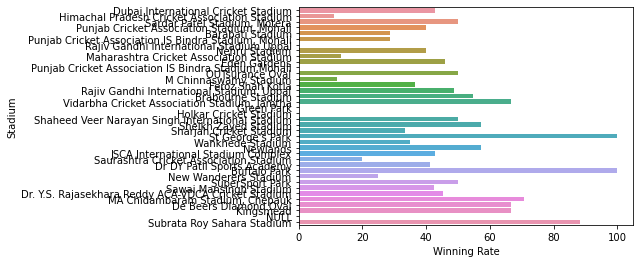

In [17]:
# plt.plot(Stadiums,Total_Matches)
sns.barplot(x=Winning_Rates,y=Stadiums,orient='h')
# plt.bar(x=Winning_Rates,y=Stadiums)


# plt.bar(Total_Matches,Batting_First_Rec)
plt.xlabel('Winning Rate')
plt.ylabel('Stadium')
plt.show()

In [24]:
fig = go.Figure(data=[go.Pie(labels=Stadiums, values=Winning_Rates, hole=.3)])

In [36]:
fig.update_layout(
    
    title_text="Stadium Wise Win Rate",
    
    annotations=[dict(text='Stadiums', x=0.49, y=0.5, font_size=18, showarrow=False)])

fig.show()